In [340]:
# https://www.kaggle.com/datasets/jainaru/thyroid-disease-data/data

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import Utils.utils as utils
import torch


df = pd.read_csv("/data/repor/analisys de datos/Data/Tiroide/Thyroid_Diff.csv")

# Normalice colums
import re
colums = df.columns.copy()
name_map = {}
for colum in colums:
    new_name  = re.sub(r'\s+', '_', str(colum)).rstrip('_')
    name_map.update({colum: new_name})

df.rename(columns=name_map, inplace=True)

df.head()

,Age,Gender,Smoking,Hx_Smoking,Hx_Radiothreapy,Thyroid_Function,Physical_Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [341]:
print(f"Duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

Duplicate rows: 19


In [342]:
print(f"None field: {df.isna().sum()}")

None field: Age                     0
Gender                  0
Smoking                 0
Hx_Smoking              0
Hx_Radiothreapy         0
Thyroid_Function        0
Physical_Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64


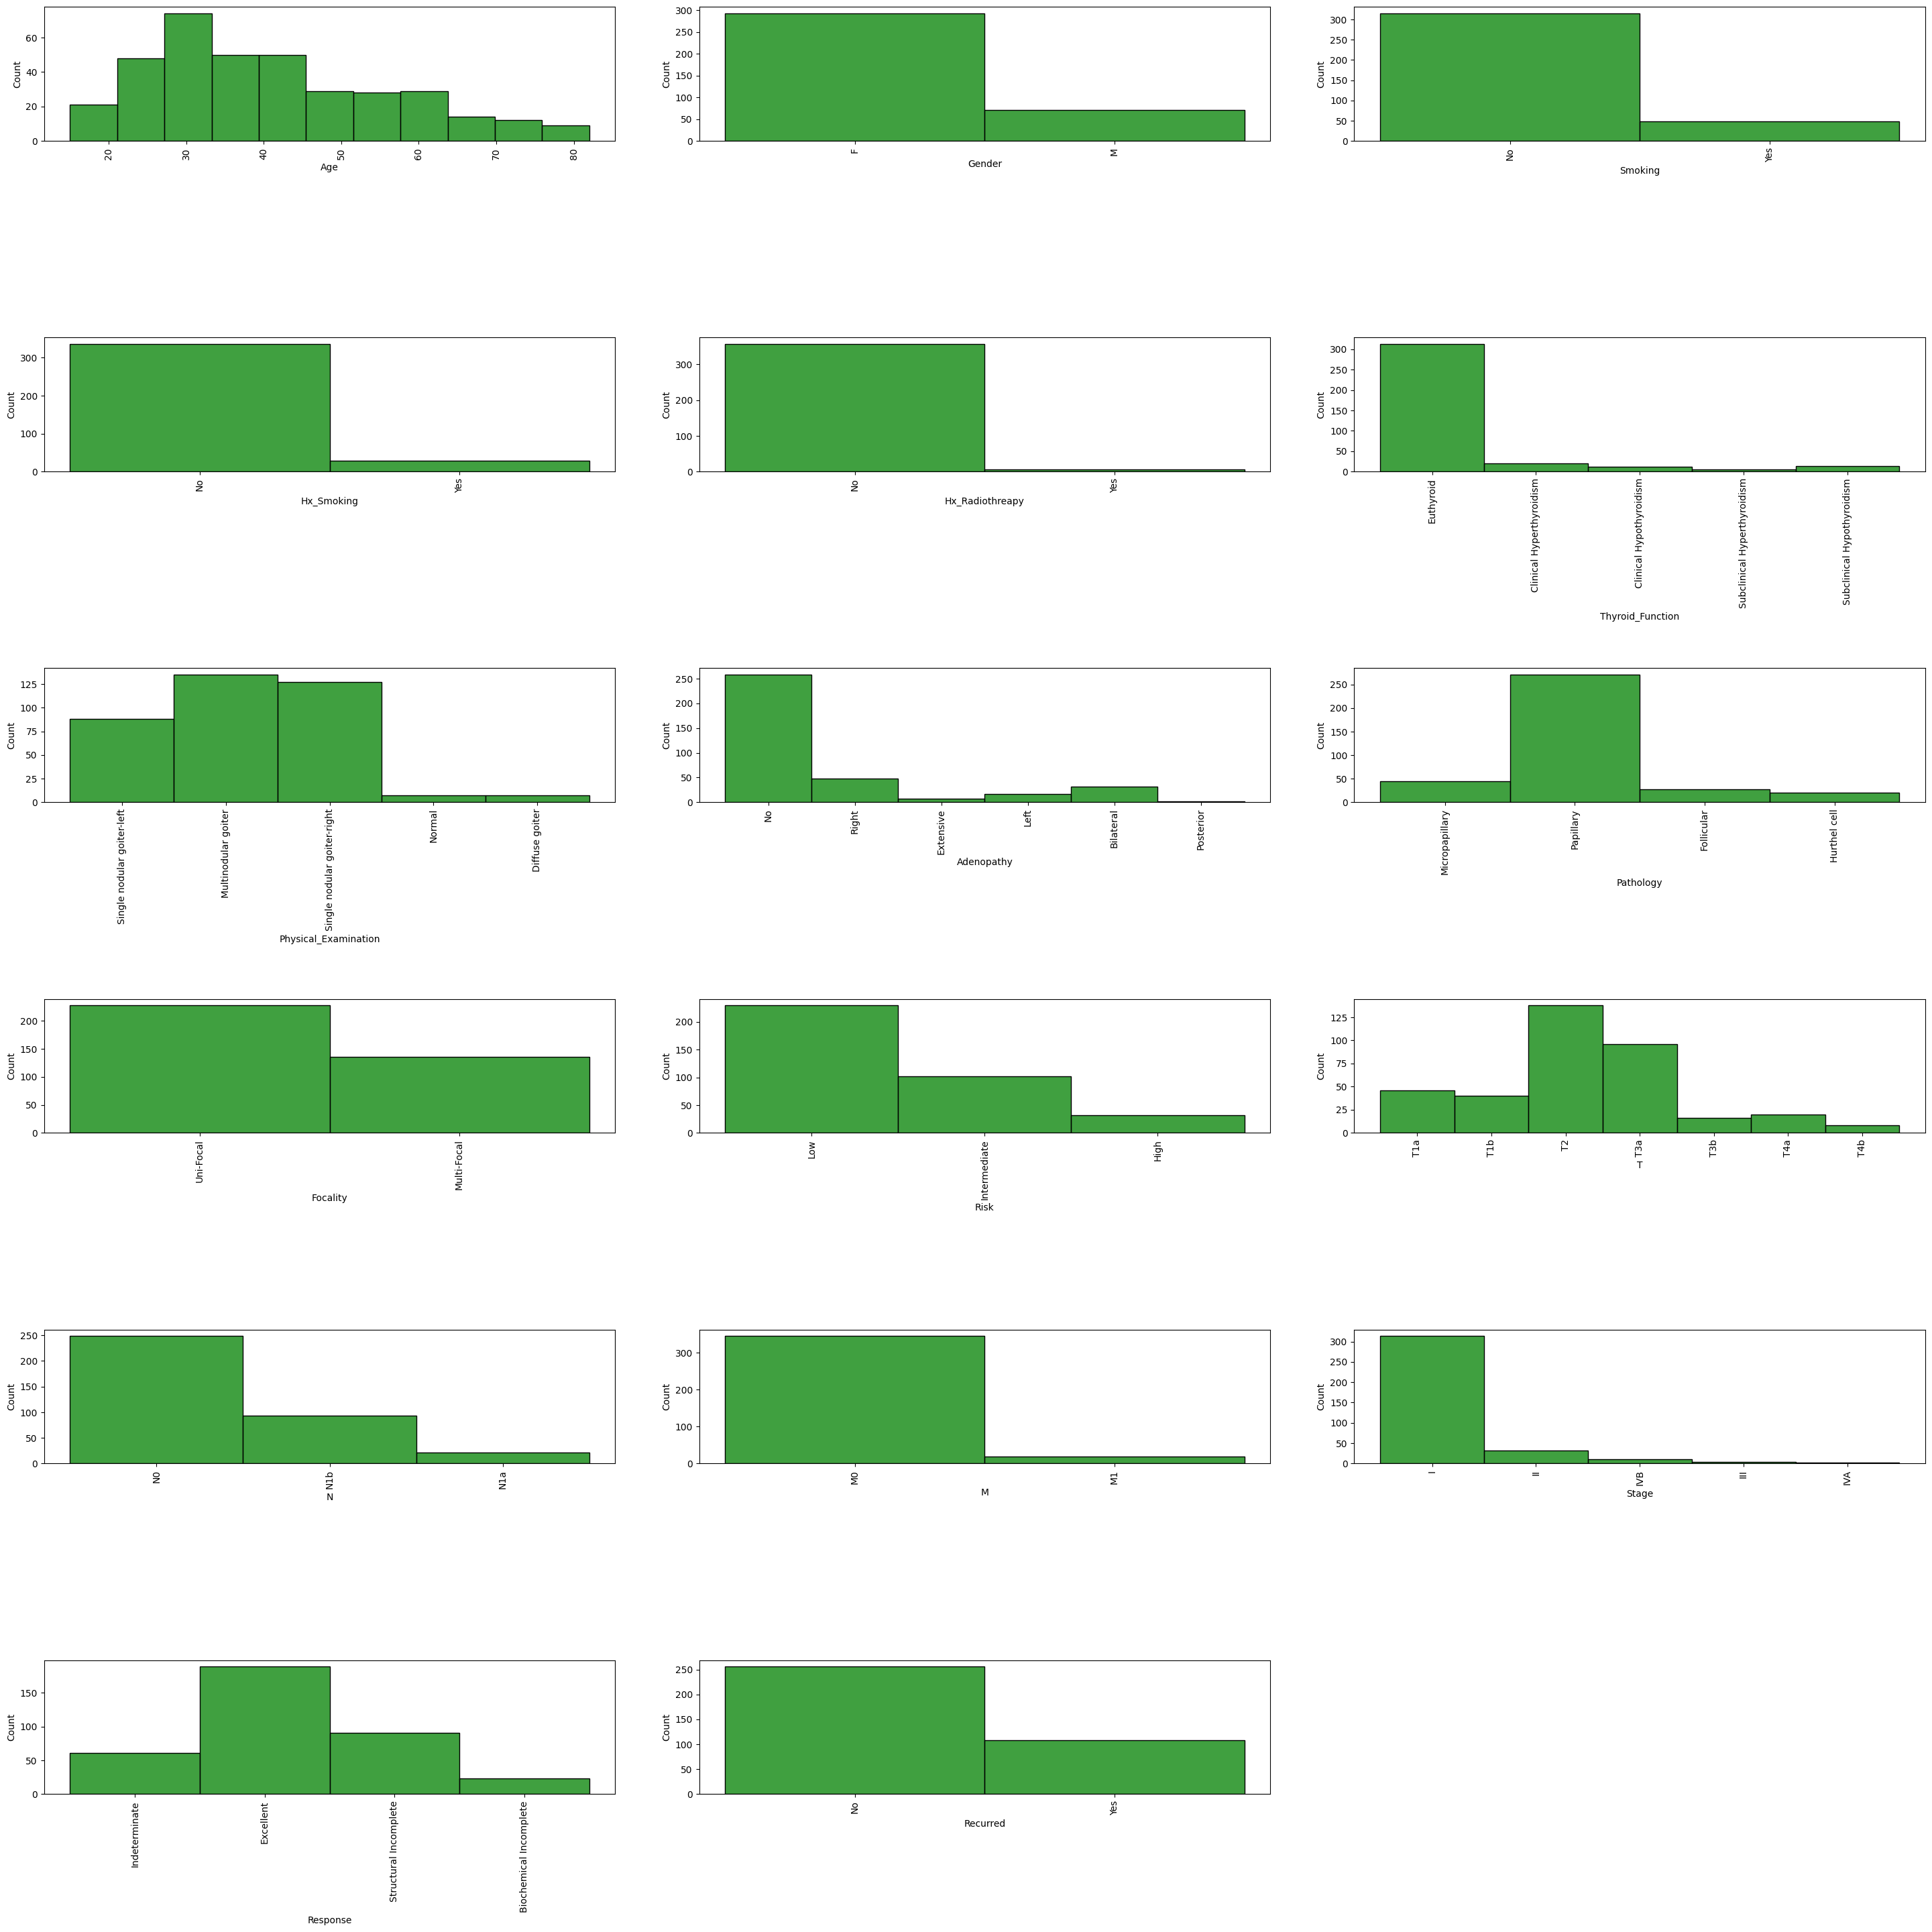

In [343]:
# hitogtrama
no_target = df.columns
plt.figure(figsize=(30,30))
for i in range(0, len(no_target)):
  plt.subplot(6, 3, i+1)
  ax = sns.histplot(x=df[no_target[i]], color='green')
  plt.tick_params(axis='x', which='major', rotation=90)
  plt.tight_layout(pad=5.0)


Suponemos que no existe relacion entre el la Respuesta(**Response**) al tratamiento y la Recaida(**Recurred**)  -> $H_0$

#### Nota
Por limitaciones el Test de fisher no puede hacerse con tablas de contingencias diferentes a $2X2$ por lo que crearemos un OneHotencodre para separa el campo Respuesta(**Response**)

In [344]:
df_contingencia = pd.get_dummies(df[['Response','Recurred']], columns=['Response'], dtype=int, prefix_sep='#')
# Normalice colums
import re
colums = df_contingencia.columns.copy()
name_map = {}
for colum in colums:
    new_name  = re.sub(r'\s+', '_', str(colum)).rstrip('_')
    name_map.update({colum: new_name})

df_contingencia.rename(columns=name_map, inplace=True)

cong_table_Response_Biochemical_Incomplete = pd.crosstab(df_contingencia['Response#Biochemical_Incomplete'], df_contingencia['Recurred'])
cong_table_Response_Excellent = pd.crosstab(df_contingencia['Response#Excellent'], df_contingencia['Recurred'])
cong_table_Response_Indeterminate = pd.crosstab(df_contingencia['Response#Indeterminate'], df_contingencia['Recurred'])
cong_table_Response_Structural_Incomplete = pd.crosstab(df_contingencia['Response#Structural_Incomplete'], df_contingencia['Recurred'])


Asumiendo que las muestras son independientes

In [345]:
# Fisher test + corrección de Bonferroni.
from scipy.stats import fisher_exact, combine_pvalues

res_Biochemical_Incomplete = fisher_exact(cong_table_Response_Biochemical_Incomplete.to_numpy(), alternative='less')
res_Excellent = fisher_exact(cong_table_Response_Excellent.to_numpy(), alternative='less')
res_Indeterminate = fisher_exact(cong_table_Response_Indeterminate.to_numpy(), alternative='less')
res_Structural_Incomplete = fisher_exact(cong_table_Response_Structural_Incomplete.to_numpy(), alternative='less')

alfa = 0.05
num_test = 4
significancia_ajustada = alfa/num_test

print(f'Nivel de significancia ajustado: {significancia_ajustada}')
print(f'fisher_Biochemical_Incomplete: {res_Biochemical_Incomplete.pvalue}  Acepto H_0 {res_Biochemical_Incomplete.pvalue <= significancia_ajustada}')
print(f'fisher_Excellent: {res_Excellent.pvalue}  Acepto H_0 {res_Excellent.pvalue <= significancia_ajustada}')
print(f'fisher_Indeterminate: {res_Indeterminate.pvalue}  Acepto H_0 {res_Indeterminate.pvalue <= significancia_ajustada}')
print(f'fisher_Structural_Incomplete: {res_Structural_Incomplete.pvalue}  Acepto H_0 {res_Structural_Incomplete.pvalue <= significancia_ajustada}')
print()

chi2_stat, combined_p_value = combine_pvalues([res_Biochemical_Incomplete.pvalue, res_Excellent.pvalue, res_Indeterminate.pvalue, res_Structural_Incomplete.pvalue], method='fisher')
print("Método de Fisher para combinar estos p-valores")
print(f"Chi2 Statistic: {chi2_stat}")
print(f"Combined p-value: {combined_p_value}")

chi2_stat, combined_p_value = combine_pvalues([res_Biochemical_Incomplete.pvalue, res_Excellent.pvalue, res_Indeterminate.pvalue, res_Structural_Incomplete.pvalue], method='tippett')
print("Método de tippett para combinar estos p-valores")
print(f"Chi2 Statistic: {chi2_stat}")
print(f"Combined p-value: {combined_p_value}")

Nivel de significancia ajustado: 0.0125
fisher_Biochemical_Incomplete: 0.9835602335749768  Acepto H_0 False
fisher_Excellent: 1.1581231769518188e-43  Acepto H_0 True
fisher_Indeterminate: 0.00026470024383971354  Acepto H_0 True
fisher_Structural_Incomplete: 1.0  Acepto H_0 False

Método de Fisher para combinar estos p-valores
Chi2 Statistic: 214.23569436257998
Combined p-value: 6.352769598857941e-42
Método de tippett para combinar estos p-valores
Chi2 Statistic: 1.1581231769518188e-43
Combined p-value: 4.632492707807275e-43


In [346]:
# boschloo Test
from scipy.stats import boschloo_exact

res_Biochemical_Incomplete = boschloo_exact(cong_table_Response_Biochemical_Incomplete.to_numpy(), alternative='less')
res_Excellent = boschloo_exact(cong_table_Response_Excellent.to_numpy(), alternative='less')
res_Indeterminate = boschloo_exact(cong_table_Response_Indeterminate.to_numpy(), alternative='less')
res_Structural_Incomplete = boschloo_exact(cong_table_Response_Structural_Incomplete.to_numpy(), alternative='less')

alfa = 0.05
num_test = 4
significancia_ajustada = alfa/num_test

print(f'Nivel de significancia ajustado: {significancia_ajustada}')
print(f'boschloo_Biochemical_Incomplete: {res_Biochemical_Incomplete.pvalue} Acepto H_0 {res_Biochemical_Incomplete.pvalue <= significancia_ajustada}')
print(f'boschloo_Excellent: {res_Excellent.pvalue} Acepto H_0 {res_Excellent.pvalue <= significancia_ajustada}')
print(f'boschloo_Indeterminate: {res_Indeterminate.pvalue} Acepto H_0 {res_Indeterminate.pvalue <= significancia_ajustada}')
print(f'boschloo_Structural_Incomplete: {res_Structural_Incomplete.pvalue} Acepto H_0 {res_Structural_Incomplete.pvalue <= significancia_ajustada}')
print()

chi2_stat, combined_p_value = combine_pvalues([res_Biochemical_Incomplete.pvalue, res_Excellent.pvalue, res_Indeterminate.pvalue, res_Structural_Incomplete.pvalue], method='fisher')
print("Método de Fisher para combinar estos p-valores")
print(f"Chi2 Statistic: {chi2_stat}")
print(f"Combined p-value: {combined_p_value}")

chi2_stat, combined_p_value = combine_pvalues([res_Biochemical_Incomplete.pvalue, res_Excellent.pvalue, res_Indeterminate.pvalue, res_Structural_Incomplete.pvalue], method='tippett')
print("Método de tippett para combinar estos p-valores")
print(f"Chi2 Statistic: {chi2_stat}")
print(f"Combined p-value: {combined_p_value}")


Nivel de significancia ajustado: 0.0125
boschloo_Biochemical_Incomplete: 0.9783667777488554 Acepto H_0 False
boschloo_Excellent: 3.9112011168604965e-44 Acepto H_0 True
boschloo_Indeterminate: 0.00018034359319810258 Acepto H_0 True
boschloo_Structural_Incomplete: 1.0 Acepto H_0 False

Método de Fisher para combinar estos p-valores
Chi2 Statistic: 217.18483380059155
Combined p-value: 1.5143001050639587e-42
Método de tippett para combinar estos p-valores
Chi2 Statistic: 3.9112011168604965e-44
Combined p-value: 1.5644804467441986e-43


Podemos notar que los p-values convinados son menores de $0.5$ por los que rechazamos $H_0$ y eliminamos la columnas **Response** por tener una alta correlacion **Recurred**

In [347]:
df.drop(columns="Response",inplace=True)


* __Age__   ->  The age of the patient at the time of diagnosis or treatment.
* __Gender__    ->  The gender of the patient (male or female).
* __Smoking__   ->  Whether the patient is a smoker or not.
* __Hx_Smoking__    ->  Smoking history of the patient (e.g., whether they have ever smoked).
* __Hx_Radiotherapy__   ->  History of radiotherapy treatment for any condition.
* __Thyroid_Function__  ->  The status of thyroid function, possibly indicating if there are any abnormalities.
* __Physical_Examination__  ->  Findings from a physical examination of the patient, which may include palpation of the thyroid gland and surrounding structures.
* __Adenopathy__    ->  Presence or absence of enlarged lymph nodes (adenopathy) in the neck region.
* __Pathology__ ->  Specific types of thyroid cancer as determined by pathology examination of biopsy samples.
* __Focality__  ->  Whether the cancer is unifocal (limited to one location) or multifocal (present in multiple locations).
* __Risk__  ->  The risk category of the cancer based on various factors, such as tumor size, extent of spread, and histological type.
* __T__ ->  Tumor classification based on its size and extent of invasion into nearby structures.
* __N__ ->  Nodal classification indicating the involvement of lymph nodes.
* __M__ ->  Metastasis classification indicating the presence or absence of distant metastases.
* __Stage__ ->  The overall stage of the cancer, typically determined by combining T, N, and M classifications.
* __Response__  ->  Response to treatment, indicating whether the cancer responded positively, negatively, or remained stable after treatment.
* __Recurred__  ->  Indicates whether the cancer has recurred after initial treatment.


In [348]:
for colum in df.columns:
    print('-'*10)
    print(f'{colum} : {df[colum].unique()}')

----------
Age : [27 34 30 62 52 41 46 51 40 75 59 49 50 76 42 44 43 36 70 60 33 26 37 55
 31 45 20 38 29 25 21 23 24 35 54 22 69 28 17 73 18 39 57 66 32 47 56 63
 19 67 72 61 68 48 81 53 58 80 79 65 15 82 71 64 78]
----------
Gender : ['F' 'M']
----------
Smoking : ['No' 'Yes']
----------
Hx_Smoking : ['No' 'Yes']
----------
Hx_Radiothreapy : ['No' 'Yes']
----------
Thyroid_Function : ['Euthyroid' 'Clinical Hyperthyroidism' 'Clinical Hypothyroidism'
 'Subclinical Hyperthyroidism' 'Subclinical Hypothyroidism']
----------
Physical_Examination : ['Single nodular goiter-left' 'Multinodular goiter'
 'Single nodular goiter-right' 'Normal' 'Diffuse goiter']
----------
Adenopathy : ['No' 'Right' 'Extensive' 'Left' 'Bilateral' 'Posterior']
----------
Pathology : ['Micropapillary' 'Papillary' 'Follicular' 'Hurthel cell']
----------
Focality : ['Uni-Focal' 'Multi-Focal']
----------
Risk : ['Low' 'Intermediate' 'High']
----------
T : ['T1a' 'T1b' 'T2' 'T3a' 'T3b' 'T4a' 'T4b']
----------
N : ['N0'

In [349]:
# Trasform data
df['Smoking'] = df['Smoking'].apply(lambda x: 1 if x == "Yes" else 0)
df['Hx_Smoking'] = df['Hx_Smoking'].apply(lambda x: 1 if x == "Yes" else 0)
df['Hx_Radiothreapy'] = df['Hx_Radiothreapy'].apply(lambda x: 1 if x == "Yes" else 0)
df['Recurred'] = df['Recurred'].apply(lambda x: 1 if x == "Yes" else 0)
df['M'] = df['M'].apply(lambda x: 1 if x == "M1" else 0)

df['Risk'] = df['Risk'].apply(lambda x: 0 if x == "Low" else 1 if x == 'Intermediate' else 2)

# One hot encode

df = pd.get_dummies(df, columns=['Gender', 'Thyroid_Function', 'Physical_Examination', 'Adenopathy', 'Pathology', 'Focality', 'T', 'N', 'Stage'], dtype=int, prefix_sep='-')

In [350]:
# Normalice colums
import re
colums = df.columns.copy()
name_map = {}
for colum in colums:
    new_name  = re.sub(r'\s+', '_', str(colum)).rstrip('_')
    name_map.update({colum: new_name})

df.rename(columns=name_map, inplace=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 382
Data columns (total 46 columns):
 #   Column                                            Non-Null Count  Dtype
---  ------                                            --------------  -----
 0   Age                                               364 non-null    int64
 1   Smoking                                           364 non-null    int64
 2   Hx_Smoking                                        364 non-null    int64
 3   Hx_Radiothreapy                                   364 non-null    int64
 4   Risk                                              364 non-null    int64
 5   M                                                 364 non-null    int64
 6   Recurred                                          364 non-null    int64
 7   Gender-F                                          364 non-null    int64
 8   Gender-M                                          364 non-null    int64
 9   Thyroid_Function-Clinical_Hyperthyroidism       

In [351]:
df.corr().style.background_gradient(cmap='coolwarm')

,Age,Smoking,Hx_Smoking,Hx_Radiothreapy,Risk,M,Recurred,Gender-F,Gender-M,Thyroid_Function-Clinical_Hyperthyroidism,Thyroid_Function-Clinical_Hypothyroidism,Thyroid_Function-Euthyroid,Thyroid_Function-Subclinical_Hyperthyroidism,Thyroid_Function-Subclinical_Hypothyroidism,Physical_Examination-Diffuse_goiter,Physical_Examination-Multinodular_goiter,Physical_Examination-Normal,Physical_Examination-Single_nodular_goiter-left,Physical_Examination-Single_nodular_goiter-right,Adenopathy-Bilateral,Adenopathy-Extensive,Adenopathy-Left,Adenopathy-No,Adenopathy-Posterior,Adenopathy-Right,Pathology-Follicular,Pathology-Hurthel_cell,Pathology-Micropapillary,Pathology-Papillary,Focality-Multi-Focal,Focality-Uni-Focal,T-T1a,T-T1b,T-T2,T-T3a,T-T3b,T-T4a,T-T4b,N-N0,N-N1a,N-N1b,Stage-I,Stage-II,Stage-III,Stage-IVA,Stage-IVB
Age,1.000000,0.305131,0.129435,0.175602,0.285706,0.233240,0.248926,-0.177827,0.177827,0.014978,-0.028171,-0.018761,-0.089901,0.096681,-0.027141,0.105338,-0.075538,0.002937,-0.079808,0.126243,0.042184,-0.036821,-0.065043,0.027946,-0.018582,0.083593,0.104059,0.063717,-0.153529,0.210916,-0.210916,0.048387,-0.149338,-0.166801,0.044435,0.035052,0.239650,0.205844,-0.028305,-0.058422,0.062091,-0.570125,0.367310,0.208498,0.141569,0.337099
Smoking,0.305131,1.000000,0.248622,0.296427,0.366606,0.318424,0.325300,-0.618390,0.618390,0.010869,-0.027742,-0.003122,-0.046546,0.046685,-0.055228,0.047106,-0.055228,0.134491,-0.136726,0.218656,0.120599,0.027143,-0.225548,-0.029316,0.060389,0.158003,0.187482,-0.099226,-0.119605,0.227818,-0.227818,-0.101557,-0.112844,-0.125703,0.019671,0.072488,0.258127,0.325181,-0.164817,-0.066255,0.211881,-0.403805,0.190230,0.190052,0.231134,0.259503
Hx_Smoking,0.129435,0.248622,1.000000,0.259860,0.130336,0.124370,0.128472,-0.170124,0.170124,0.066125,0.004442,-0.121095,0.054509,0.103098,-0.040423,0.055822,0.034648,-0.090763,0.026623,0.128832,0.034648,-0.063895,-0.109973,-0.021457,0.070318,0.032738,0.111369,0.016866,-0.090919,-0.009836,0.009836,0.014321,-0.002536,-0.119327,-0.055792,0.139272,0.111369,0.167688,-0.025589,-0.029952,0.043641,-0.184310,-0.016804,0.266254,0.087719,0.189937
Hx_Radiothreapy,0.175602,0.296427,0.259860,1.000000,0.270615,0.429394,0.171796,-0.233975,0.233975,0.141808,-0.025854,-0.058740,-0.016525,-0.028006,-0.019608,0.016724,-0.019608,0.014376,-0.018564,-0.043473,0.417367,-0.030994,-0.086368,-0.010408,0.004548,0.109718,0.054022,-0.052593,-0.055569,0.098605,-0.098605,-0.053257,0.014760,-0.068190,-0.083808,-0.030025,0.141808,0.388335,-0.076957,-0.035515,0.101435,-0.292797,0.027171,-0.014760,0.208496,0.442688
Risk,0.285706,0.366606,0.130336,0.270615,1.000000,0.501961,0.727404,-0.283486,0.283486,-0.020756,-0.058432,0.015296,-0.082664,0.101270,-0.098083,0.222179,-0.036633,-0.040721,-0.149773,0.378595,0.239890,0.184925,-0.637689,0.176266,0.288208,0.082830,0.053314,-0.250262,0.110411,0.435928,-0.435928,-0.228308,-0.165163,-0.321222,0.155315,0.220313,0.516247,0.355490,-0.685783,0.158780,0.644231,-0.615329,0.348792,0.209494,0.216179,0.418616
M,0.233240,0.318424,0.124370,0.429394,0.501961,1.000000,0.351161,-0.207512,0.207512,0.000611,-0.042113,0.019056,-0.026918,0.020274,-0.031938,-0.017729,-0.031938,0.137572,-0.087208,0.063435,0.152595,0.129676,-0.188494,0.154465,0.023458,0.171923,-0.054996,-0.085666,-0.011653,0.216742,-0.216742,-0.086749,-0.080141,-0.152114,-0.050243,0.136531,0.334256,0.311523,-0.226593,0.101674,0.185975,-0.534770,0.242431,-0.024042,-0.020792,0.699927
Recurred,0.248926,0.325300,0.128472,0.171796,0.727404,0.351161,1.000000,-0.317731,0.317731,-0.077436,-0.052560,0.088918,-0.076653,0.026462,-0.090951,0.148721,-0.003369,-0.001544,-0.122160,0.371792,0.215587,0.198263,-0.616199,0.114438,0.280100,0.083333,0.001740,-0.243951,0.132287,0.368581,-0.368581,-0.228934,-0.132070,-0.259631,0.170824,0.271450,0.344839,0.230796,-0.606458,0.087638,0.598548,-0.492070,0.329315,0.162288,0.140351,0.271780
Gender-F,-0.177827,-0.618390,-0.170124,-0.233975,-0.283486,-0.207512,-0.317731,1.000000,-1.000000,-0.0

In [352]:
df.corr().query(f'(Recurred >= 0.2 or Recurred <= -0.2) and Recurred != 1.0')[['Recurred']].style.background_gradient(cmap='coolwarm')

,Recurred
Age,0.248926
Smoking,0.325300
Risk,0.727404
M,0.351161
Gender-F,-0.317731
Gender-M,0.317731
Adenopathy-Bilateral,0.371792
Adenopathy-Extensive,0.215587
Adenopathy-No,-0.616199
Adenopathy-Right,0.280100


dict

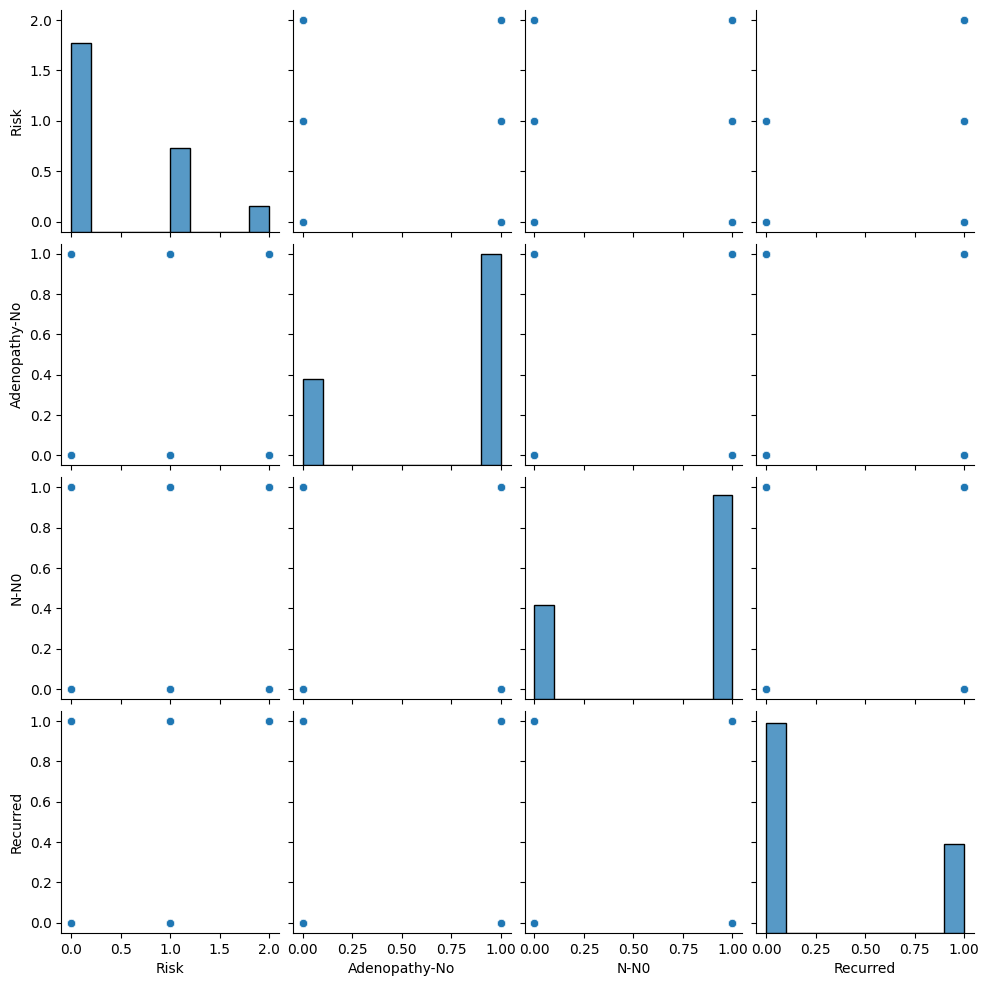

In [353]:
colums = ['Risk','Adenopathy-No', 'N-N0', 'Recurred']
sns.pairplot(df[colums])
dict

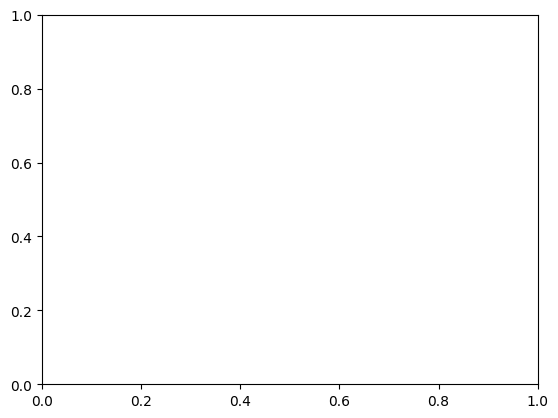

In [354]:
groups_feature = df['Risk'].unique()
groups_tag = df['Recurred'].unique()
count_group_tag = {}
for group in groups_feature:
    for traget in groups_tag:
        num_by_target = df[(df['Risk'] == group) & (df['Recurred']== traget)].shape[0]
        tag_dict = count_group_tag.get(group, {})
        tag_dict.update({traget:num_by_target})
        count_group_tag.update({group:tag_dict})

fig, ax = plt.subplots()


In [355]:
count_group_tag.values()

dict_values([{0: 218, 1: 12}, {0: 38, 1: 64}, {0: 0, 1: 32}])

In [356]:
[x.get(0,0) for x in count_group_tag.values()]

[218, 38, 0]

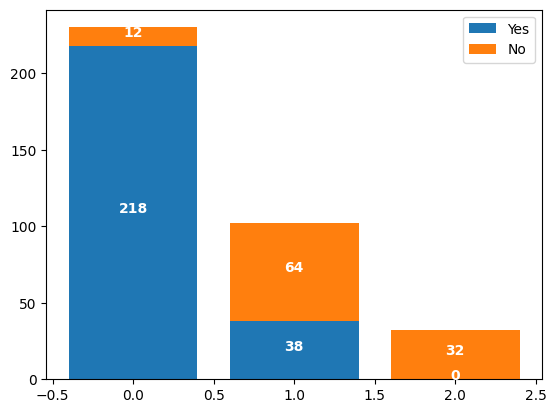

In [357]:
df[['Risk', 'Recurred']]
# Data
groups = df['Risk'].unique()
values1 = [x.get(0,0) for x in count_group_tag.values()]
values2 = [x.get(1,0) for x in count_group_tag.values()]

fig, ax = plt.subplots()

# Stacked bar chart
ax.bar(groups, values1, label = "Yes")
ax.bar(groups, values2, bottom = values1, label = "No")

# Labels
for bar in ax.patches:
  ax.text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height()), ha = 'center',
          color = 'w', weight = 'bold', size = 10)

ax.legend()


Se opserve que el riesgo 

In [358]:
colums = ['Age', 'Recurred']
df[colums].corr().style.background_gradient(cmap='coolwarm')

,Age,Recurred
Age,1.000000,0.248926
Recurred,0.248926,1.000000


In [359]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Recurred"]), df['Recurred'], test_size = 0.30, random_state=48)

In [360]:
type(X_train.to_numpy())

numpy.ndarray

In [361]:
class MultiScores:
    def __init__(self) -> None:
        self._realResult = []
        self._stimate_result = []
    
    def score(self, stimator, values, realResult):
        # print(f"stimator: {type(stimator)} | values: {type(values)} | realResult: {type(realResult)}")
        model_fit = stimator.fit()

    

In [362]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score


models = []

models.append(("LogisticRegression",LogisticRegression(max_iter=10000,random_state= 15)))
models.append(("SVC",SVC(max_iter=4000)))
models.append(("LinearSVC",LinearSVC(dual='auto', max_iter=40000)))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier(random_state= 15)))
models.append(("RandomForest",RandomForestClassifier(random_state= 15)))
rf2 = RandomForestClassifier(n_estimators=5, min_samples_split=2, random_state= 15)
models.append(("RandomForest2",rf2))
models.append(("MLPClassifier",MLPClassifier(solver='adam', random_state=0,max_iter=10000)))



results = []
names = []

fit_models = {}
for name,model in models:
    fit_model = model.fit(X_train, y_train)
    scorer = MultiScores()
    result = cross_val_score(model, df.drop(columns=["Recurred"]), df['Recurred'],  cv=10, scoring='f1')
    names.append(name)
    results.append(result)
    fit_models.update({name:{"model":fit_model, "mean": result.mean()}})

for i in range(len(names)):
    print(names[i],results[i].mean(), results[i].std())

LogisticRegression 0.6896795500456827 0.2387217210341563
SVC 0.22036199095022627 0.2151997064239558
LinearSVC 0.6460045729371692 0.2546973170166895
KNeighbors 0.5977923976608188 0.19890769149546964
DecisionTree 0.5255495009373259 0.24536773824878758
RandomForest 0.6127300009072455 0.2463764804267317
RandomForest2 0.6518273474391065 0.15457971076697977
MLPClassifier 0.6080894062078273 0.27406090661242216


In [363]:
X_train

,Age,Smoking,Hx_Smoking,Hx_Radiothreapy,Risk,M,Gender-F,Gender-M,Thyroid_Function-Clinical_Hyperthyroidism,Thyroid_Function-Clinical_Hypothyroidism,...,T-T4a,T-T4b,N-N0,N-N1a,N-N1b,Stage-I,Stage-II,Stage-III,Stage-IVA,Stage-IVB
181,45,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
293,26,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
113,32,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
257,34,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
28,41,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,48,0,0,0,1,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
366,64,0,1,0,2,1,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
356,54,1,0,0,1,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
54,25,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [364]:
from sklearn.inspection import permutation_importance


rf = fit_models["KNeighbors"]['model']

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({'Feature': X_train.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance
# len()
# rf.coef_[0]
# # rf.feature_names()
# # utils.importance_features(rf)
# utils.importance_features(rf)

,Feature,Importance,Standard Deviation
4,Risk,0.041818,0.008332
37,N-N0,0.030000,0.009136
5,M,0.012727,0.006030
21,Adenopathy-No,0.011818,0.012889
39,N-N1b,0.009091,0.009091
34,T-T3b,0.009091,0.000000
16,Physical_Examination-Single_nodular_goiter-left,0.008182,0.010325
44,Stage-IVB,0.008182,0.002727
32,T-T2,0.007273,0.010602
18,Adenopathy-Bilateral,0.007273,0.003636


In [365]:
rf = fit_models["RandomForest"]['model']
len(rf.estimators_)

utils.importance_features(rf)

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({'Feature': X_train.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance

,Feature,Importance,Standard Deviation
4,Risk,0.020000,0.011355
1,Smoking,0.013636,0.006098
5,M,0.007273,0.003636
28,Focality-Multi-Focal,0.006364,0.004166
29,Focality-Uni-Focal,0.005455,0.010909
21,Adenopathy-No,0.000909,0.008576
34,T-T3b,0.000909,0.004896
22,Adenopathy-Posterior,0.000000,0.000000
15,Physical_Examination-Normal,0.000000,0.000000
24,Pathology-Follicular,0.000000,0.000000


In [366]:
print(df[df["Recurred"]==1].shape[0]/ df['Recurred'].shape[0] *100)
print(df[df["Recurred"] == 0].shape[0]/df['Recurred'].shape[0]*100)

29.67032967032967
70.32967032967034


Es dificil entrenar a un modelo competente ya que los datos presentan una tendencia negativa en el campor **Recurred**. Solo el 29% de los datos confirma una recaida

#### Opciones de solucion
1. Cambiar metricas ROC-AUC, F1-score, precision-recall curve
2. Generar datos sinteticos {pip install imbalanced-learn} y aplicar dorp out para evitar sobreajuste


__Nota__:
Es necesario normalizar las edades y para que esten en un rango de 0 a 1 si no la red se dobrecarga y las prediciones fallan


In [367]:
# Normalice Age
from sklearn.preprocessing import MinMaxScaler
scalerAge = MinMaxScaler()
scalerAge.fit(df["Age"].to_numpy().reshape(-1, 1))
df["Age"] = scalerAge.fit_transform(df["Age"].to_numpy().reshape(-1, 1)).flatten()

Custon net

In [368]:
# Model data

class Model(torch.nn.Module):
    def __init__(self, num_input=45, H=5):
        super(Model, self).__init__()
        self.lineal_1 = torch.nn.Linear(num_input, H)
        self.relu_1 = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.2)
        self.lineal_2 = torch.nn.Linear(H, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.dropout(x)
        x = self.lineal_1(x)
        x = self.relu_1(x)
        x = self.lineal_2(x)
        x = self.sigmoid(x)
        return x

In [369]:

model = Model()
outputs = model(torch.randn(64, 45))
outputs.shape


torch.Size([64, 1])

In [370]:
# Data format
from torch.utils.data import Dataset

class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def create_dataSet(dataFrame: pd.DataFrame, predit_field: str, test_size=0.30, validtion_size=None, randon_state=48, use_gpu = False):

    """
        Parameters
        ----------
        dataFrame: Data to split in format Dataframe
        predit_field: Predite field
        test_size: If validtion_size is None then [ dataset_train = total_data * test_size ] else [  dataset_train = (total_data - (total_data * validtion_size)) * test_size ]
        validtion_size: Create subSet
        randon_state: randon_state
        use_gpu: load data in gpu
    """
    smote = SMOTE(random_state=42)
    if validtion_size is not None:
        X_validation, X_, y_validation, Y_ = train_test_split(dataFrame.drop(columns=[predit_field]), dataFrame[predit_field], test_size = validtion_size, random_state=randon_state)
        X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size = test_size, random_state=randon_state)
        X_Train_res, y_Train_res = smote.fit_resample(X_train, y_train)
        train_dataSet = DataSet(X_Train_res.to_numpy(), y_Train_res.to_numpy())
        validation_dataSet = DataSet(X_validation.to_numpy(), y_validation.to_numpy())
        test_dataSet = DataSet(X_test.to_numpy(), y_test.to_numpy())
        return train_dataSet, test_dataSet, validation_dataSet

    else:
        X_train, X_test, y_train, y_test = train_test_split(dataFrame.drop(columns=[predit_field]), dataFrame[predit_field], test_size = test_size, random_state=randon_state)
        X_Train_res, y_Train_res = smote.fit_resample(X_train, y_train)
        train_dataSet = DataSet(X_Train_res.to_numpy(), y_Train_res.to_numpy())
        test_dataSet = DataSet(X_test.to_numpy(), y_test.to_numpy())
        return train_dataSet, test_dataSet, None

In [371]:
train_dataSet, test_dataSet, _ = create_dataSet(df, 'Recurred')

In [372]:
dataloader_trainig = torch.utils.data.DataLoader(train_dataSet, batch_size=10, shuffle=True)

In [373]:
def softmax(x):
    print(torch.exp(x))
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def evaluate(x):
    model.eval()
    y_pred = model(x).view(-1)
    return(y_pred > 0.5).int()
    
    # # print(y_pred)
    # y_probas = softmax(y_pred)
    # print(y_probas)
    # return torch.argmax(y_probas, axis=1)

In [374]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# model.cuda()

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 10
log_each = 1
l = []
model.train()
for e in range(1, epochs+1): 
    
    _l = []
    # iteramos por batches en el dataloader
    for x_b, y_b in dataloader_trainig:
        # forward
        # print(x_b)
        
        y_pred = model(x_b).view(-1)
        # print(y_b.shape)
        # loss
        loss = criterion(y_pred, y_b)
        _l.append(loss.item())
        # print(loss.item())

        # ponemos a cero los gradientes
        optimizer.zero_grad()

        # Backprop (calculamos todos los gradientes automáticamente)
        loss.backward()

        # update de los pesos
        optimizer.step()
    
    l.append(np.mean(_l))
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")
        
y_pred = evaluate(test_dataSet[:][0])
print(f'F1 score: {f1_score(test_dataSet[:][1], y_pred.cpu().numpy())}')
print(f'Accuracy score: {accuracy_score(test_dataSet[:][1], y_pred.cpu().numpy())}')


Epoch 1/10 Loss 0.64717
Epoch 2/10 Loss 0.56368
Epoch 3/10 Loss 0.50601
Epoch 4/10 Loss 0.46846
Epoch 5/10 Loss 0.44182
Epoch 6/10 Loss 0.42863
Epoch 7/10 Loss 0.41544
Epoch 8/10 Loss 0.40328
Epoch 9/10 Loss 0.39199
Epoch 10/10 Loss 0.38690
F1 score: 0.825
Accuracy score: 0.8727272727272727


In [322]:
# print(((train_dataSet[:][1]==0).sum()/train_dataSet[:][1].shape[0]))
# print(((train_dataSet[:][1]==1).sum()/train_dataSet[:][1].shape[0]))

# print(test_dataSet[0][0])
# print(test_dataSet[1][0])

# model.eval()
# print(test_dataSet[0][1])
# print(test_dataSet[1][1])
# print(model(test_dataSet[0][0]))
# print(model(test_dataSet[1][0]))


tensor(0.5000)
tensor(0.5000)


In [375]:
print(f' Errors {(y_pred != test_dataSet[:][1]).sum()} / {y_pred.shape[0]}')


 Errors 14 / 110
